In [1]:
from torchvision.transforms import transforms
from torchvision import datasets
import torchvision.utils as vutils
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

def backup_colab_content_to_drive(folder_name='Colab Notebooks'):
  import shutil
  import os

  src = '/content'
  dest = f'/content/drive/MyDrive/{folder_name}'
  os.makedirs(dest, exist_ok=True)

  for item in os.listdir(src):
    if item == 'drive':
      continue
    s = os.path.join(src, item)
    d = os.path.join(dest, item)
    if os.path.isdir(s):
      shutil.copytree(s, d)
    else:
      shutil.copy2(s, d)

  print(f'Backup complete. Files saved to: {dest}')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Part 1

1. Data preparation

In [3]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)

img_tensor, label = train_dataset[0]
print(f"Shape {img_tensor.shape}, label {label}")

Shape torch.Size([1, 28, 28]), label 5


In [4]:
test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transform, download=True
)

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

2. Model creation

In [5]:
class Encoder(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
    self.fc1 = nn.Linear(64 * 7 * 7, 16)
    self.fc_mean = nn.Linear(16, latent_dim)
    self.fc_log_var = nn.Linear(16, latent_dim)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    z_mean = self.fc_mean(x)   # mu
    z_log_var = self.fc_log_var(x)   # logvar
    std = torch.exp(0.5 * z_log_var)
    eps = torch.randn_like(std)
    z = z_mean + eps * std    # reparametrization trick
    return z, z_mean, z_log_var


class Decoder(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
    self.deconv1 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1)
    self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
    self.out = nn.Conv2d(32, 1, 3, padding=1)

  def forward(self, z):
    x = F.relu(self.fc(z))
    x = x.view(-1, 64, 7, 7)
    x = F.relu(self.deconv1(x))
    x = F.relu(self.deconv2(x))
    x = torch.sigmoid(self.out(x))
    return x


class VAE(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.encoder = Encoder(latent_dim)
    self.decoder = Decoder(latent_dim)

  def forward(self, x):
    z, z_mean, z_log_var = self.encoder(x)
    recon_x = self.decoder(z)
    return recon_x, z_mean, z_log_var

3. Loss function creation

In [6]:
def loss_function(recon_x, x, mu, logvar):
  recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return recon_loss + kl_loss

Other functions for visualization and model saving:

In [7]:
def show_generation(model, epoch, latent_dim, device, save_dir):
  model.eval()

  with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    samples = model.decoder(z).cpu()
    grid = vutils.make_grid(samples, nrow=8, padding=2, normalize=True)

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated Images - Epoch {epoch}')
    plt.imshow(grid.permute(1, 2, 0))

    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f'{save_dir}/epoch_{epoch:02d}.png')
    plt.show()
    plt.close()

In [55]:
def plot_training_loss(train_losses: list, save_dir):
  plt.figure(figsize=(8, 5))
  plt.plot(range(1, len(train_losses)+1, 1), train_losses, marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Average Loss')
  plt.title('Average Training Loss per Epoch')

  os.makedirs(save_dir, exist_ok=True)
  plt.savefig(f'{save_dir}/{experiment_name}_loss_plot.png')

  plt.show()
  plt.close()


def save_model(model, save_dir):
  os.makedirs(save_dir, exist_ok=True)
  torch.save(model.state_dict(), f'{save_dir}/{experiment_name}_vae_model.pt')


def plot_latent_space(decoder, save_dir, latent_dim, n=30, figsize=15, z1_idx=0, z2_idx=1):
  digit_size = 28
  scale = 2.0

  figure = np.zeros((digit_size * n, digit_size * n))

  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[::-1]

  decoder.eval()

  with torch.no_grad():
    for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
        z = torch.zeros((1, latent_dim), dtype=torch.float32).to(device)
        z[0, z1_idx] = xi
        z[0, z2_idx] = yi
        x_decoded = decoder(z).cpu().numpy()[0, 0]
        figure[
          i * digit_size : (i + 1) * digit_size,
          j * digit_size : (j + 1) * digit_size
        ] = x_decoded

  plt.figure(figsize=(figsize, figsize))
  plt.imshow(figure, cmap='Greys_r')
  plt.axis('off')
  plt.title('Latent Space Visualization')

  os.makedirs(save_dir, exist_ok=True)
  plt.savefig(f'{save_dir}/{experiment_name}_latent_space_plot.png')

  plt.show()
  plt.close()

# 4. Experiment 1

Epoch 1, Loss: 224.6499


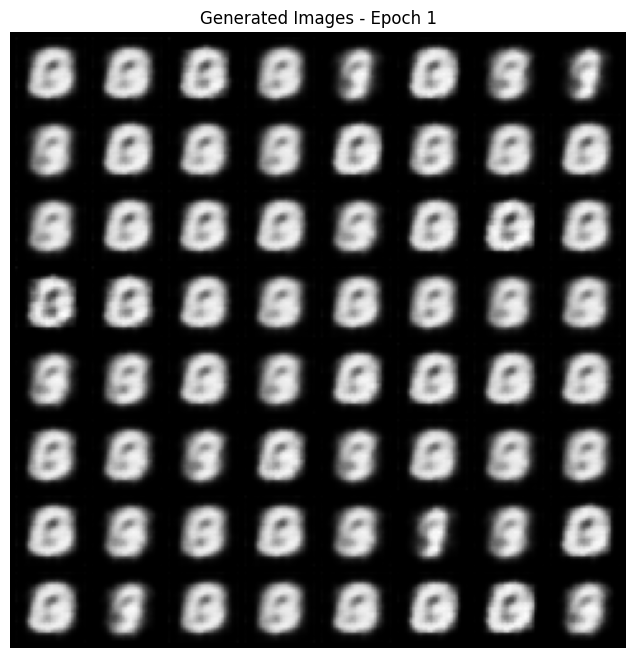

Epoch 2, Loss: 185.9322
Epoch 3, Loss: 170.9067
Epoch 4, Loss: 167.2121
Epoch 5, Loss: 164.4100
Epoch 6, Loss: 162.4952


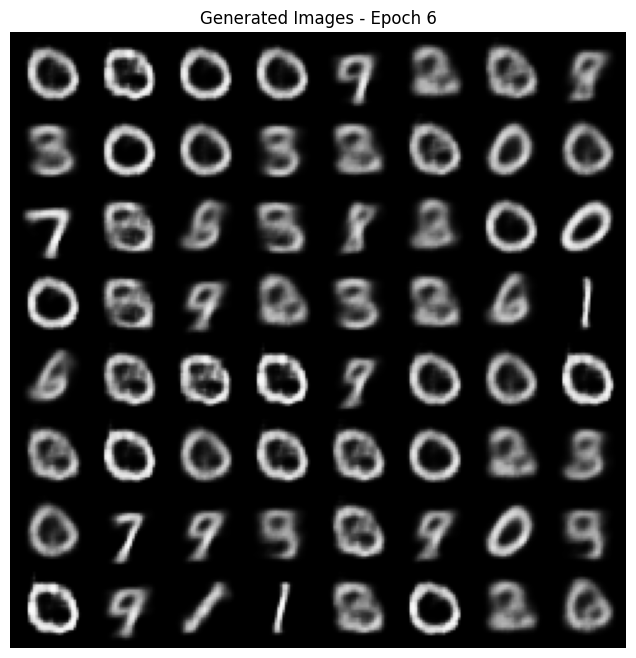

Epoch 7, Loss: 161.1125
Epoch 8, Loss: 160.1414
Epoch 9, Loss: 159.4367
Epoch 10, Loss: 158.6114
Epoch 11, Loss: 158.1010


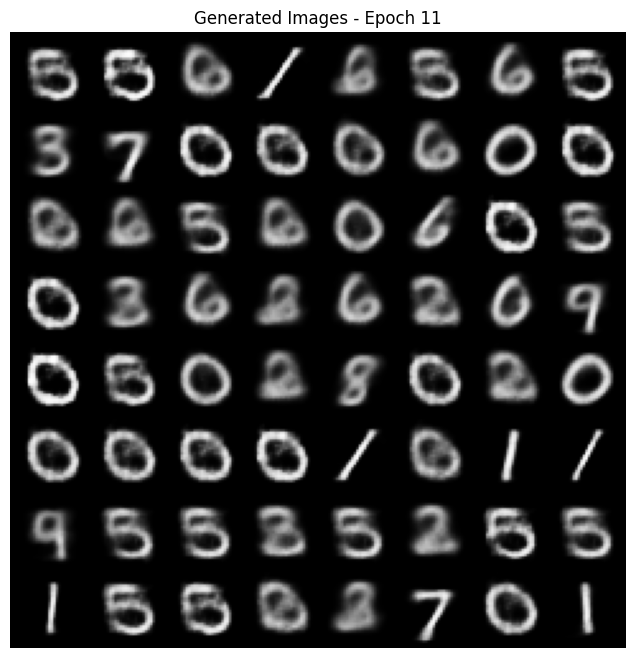

Epoch 12, Loss: 157.5362
Epoch 13, Loss: 157.1670
Epoch 14, Loss: 156.8029
Epoch 15, Loss: 156.4396
Epoch 16, Loss: 156.1778


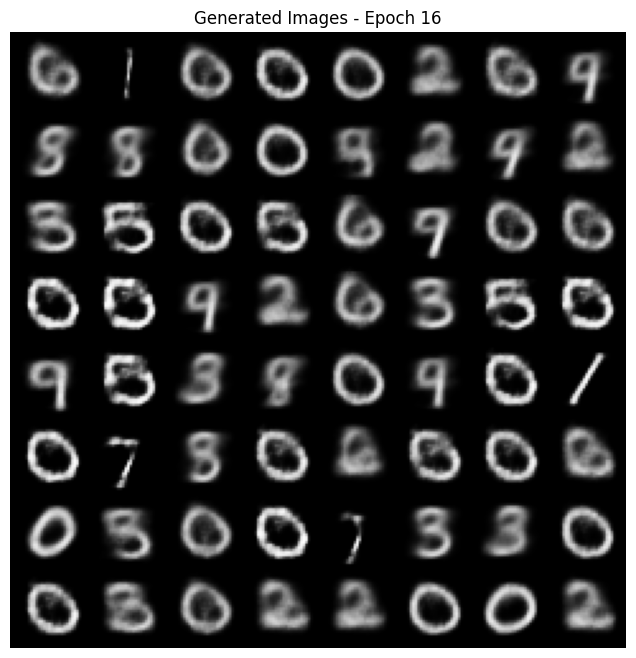

Epoch 17, Loss: 155.8991
Epoch 18, Loss: 155.6051
Epoch 19, Loss: 155.4653
Epoch 20, Loss: 155.1885
Epoch 21, Loss: 155.1352


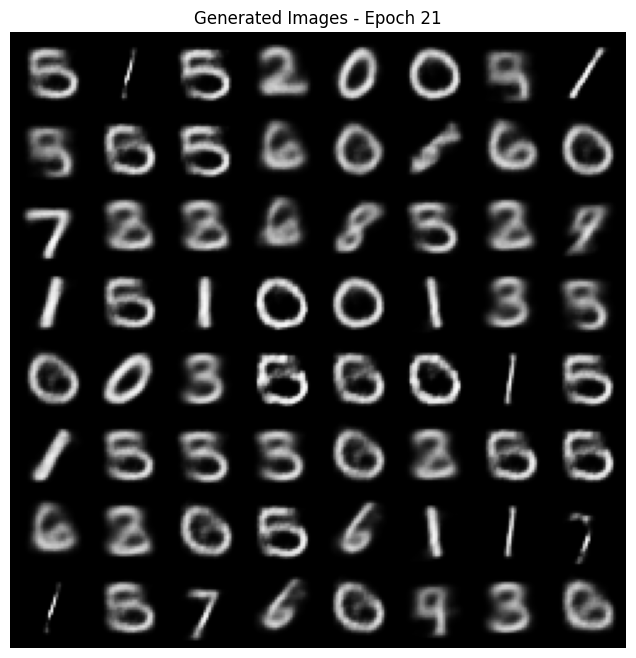

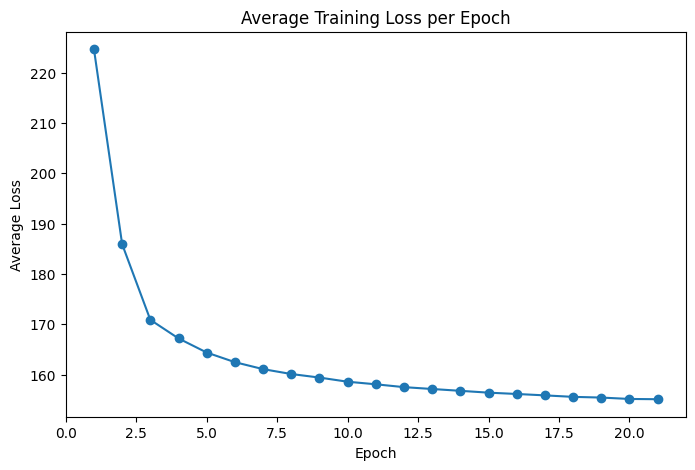

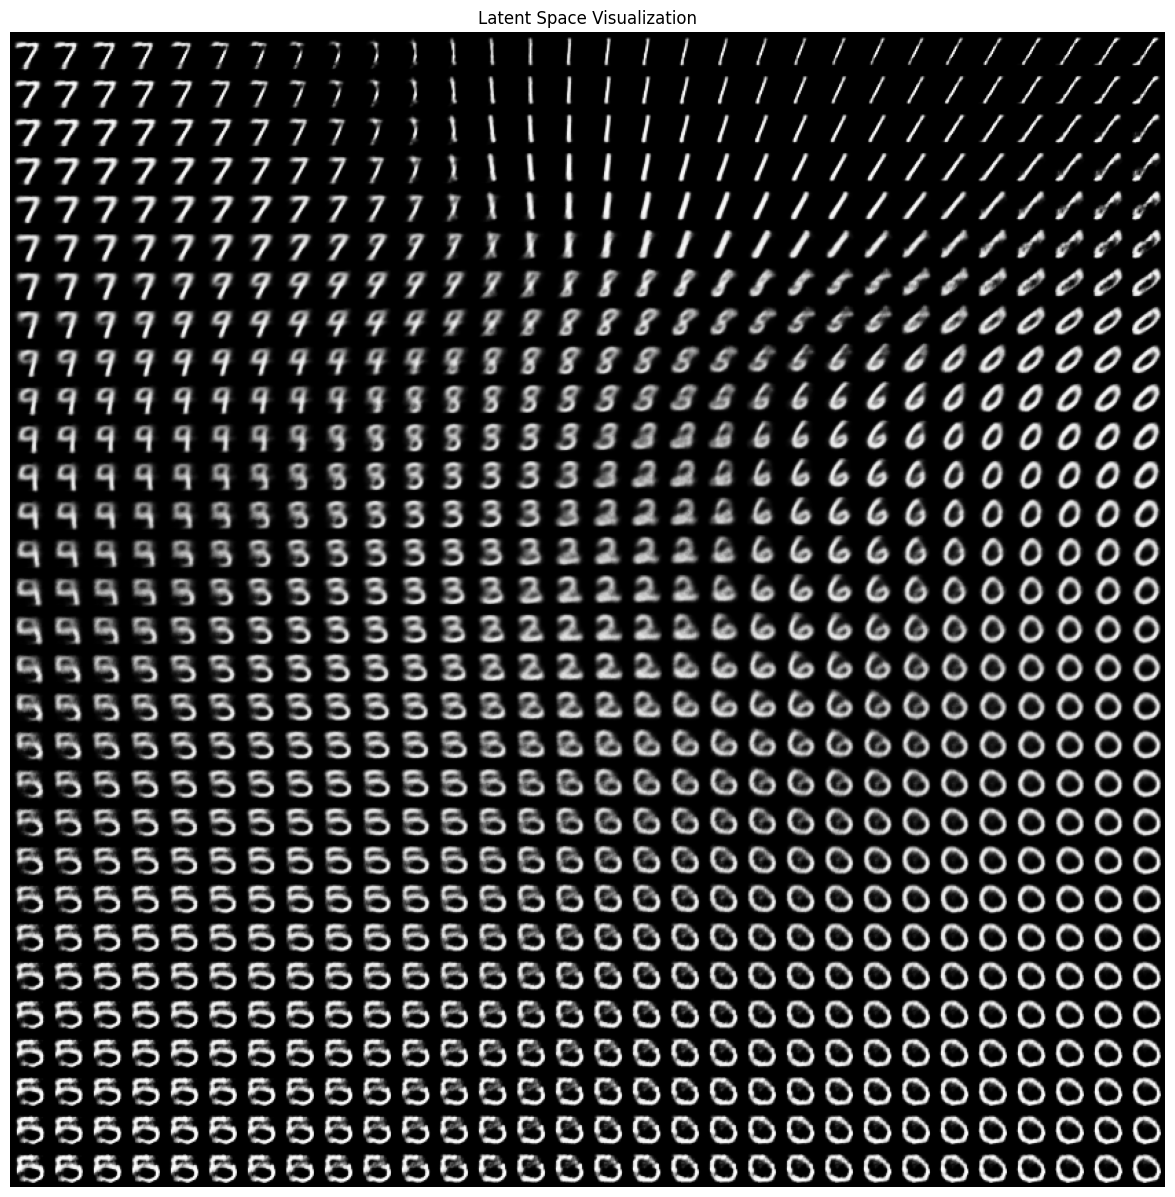

In [9]:
latent_dim = 2
save_dir = 'experiment1'
experiment_name = 'exp1'

epochs = 21
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

train_losses = []
for epoch in range(epochs):
  vae.train()

  train_loss = 0
  for batch in train_loader:
    x, _ = batch
    x = x.to(device)
    optimizer.zero_grad()
    recon_x, mu, logvar = vae(x)
    loss = loss_function(recon_x, x, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()

  avg_loss = train_loss / len(train_loader.dataset)
  train_losses.append(avg_loss)
  print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

  if epoch % 5 == 0:
    show_generation(vae, epoch+1, latent_dim, device, save_dir)

# Plot loss
plot_training_loss(train_losses, save_dir)

# Save model
save_model(vae, save_dir)

# Load model
model_loaded = VAE(latent_dim).to(device)
model_loaded.load_state_dict(torch.load(f'{save_dir}/{experiment_name}_vae_model.pt'))

# Plot latent space
plot_latent_space(model_loaded.decoder, save_dir, latent_dim)

# Part 2

# 6. Experiment 2. Increased latent space dimensionality

Epoch 1, Loss: 213.8605


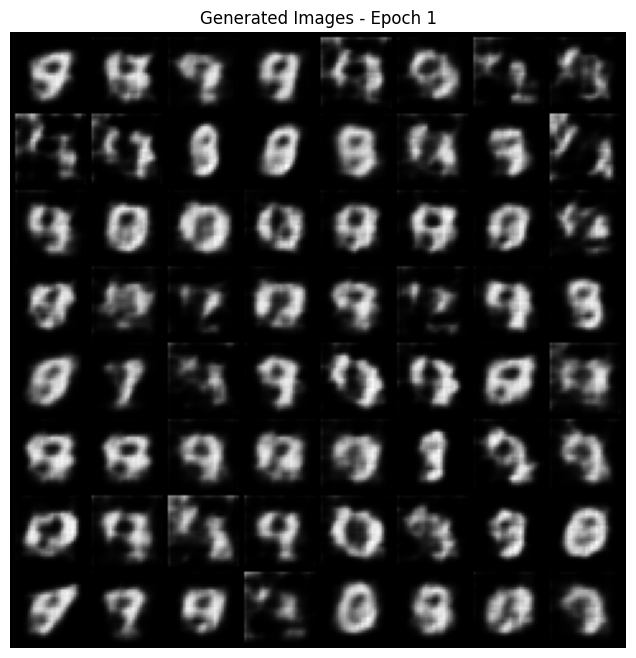

Epoch 2, Loss: 160.6485
Epoch 3, Loss: 149.1708
Epoch 4, Loss: 145.1136
Epoch 5, Loss: 142.6007
Epoch 6, Loss: 140.7644


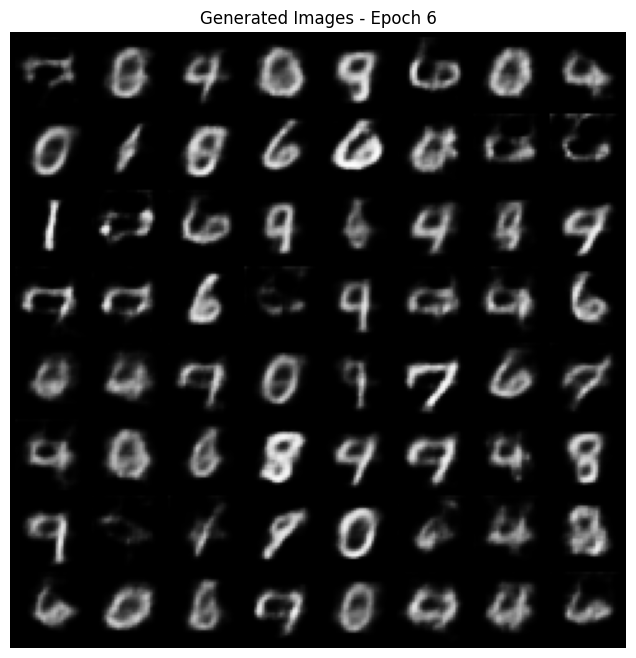

Epoch 7, Loss: 139.3324
Epoch 8, Loss: 138.0918
Epoch 9, Loss: 137.0348
Epoch 10, Loss: 136.0732
Epoch 11, Loss: 135.2554


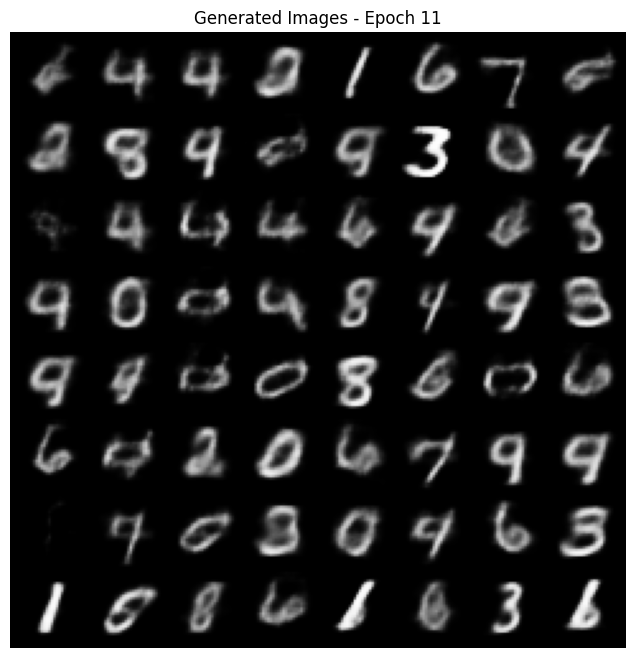

Epoch 12, Loss: 134.4721
Epoch 13, Loss: 133.8176
Epoch 14, Loss: 133.1928
Epoch 15, Loss: 132.7007
Epoch 16, Loss: 132.1715


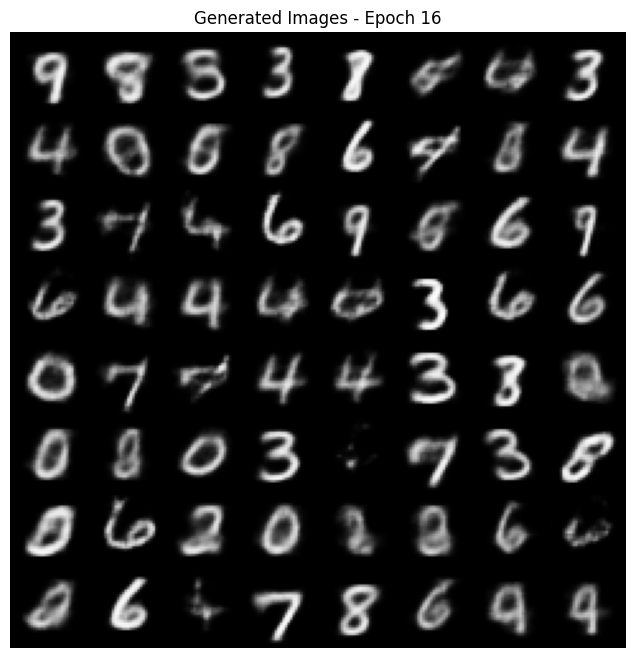

Epoch 17, Loss: 131.6524
Epoch 18, Loss: 131.3587
Epoch 19, Loss: 130.9340
Epoch 20, Loss: 130.5820
Epoch 21, Loss: 130.2461


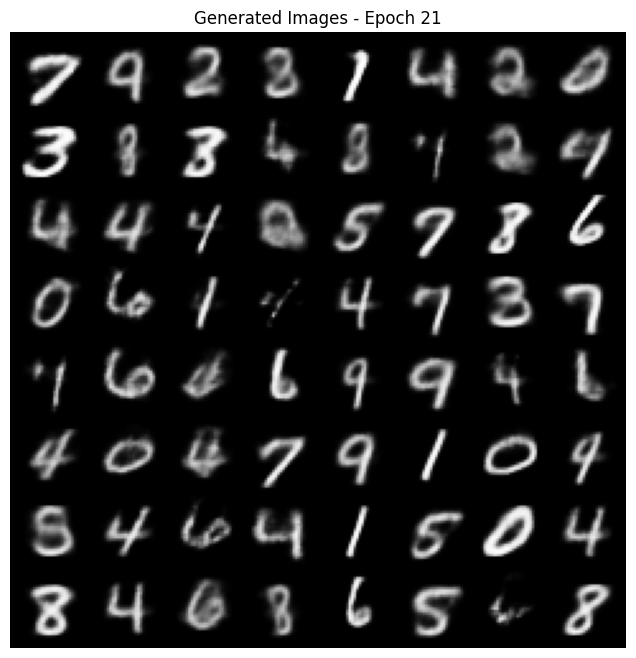

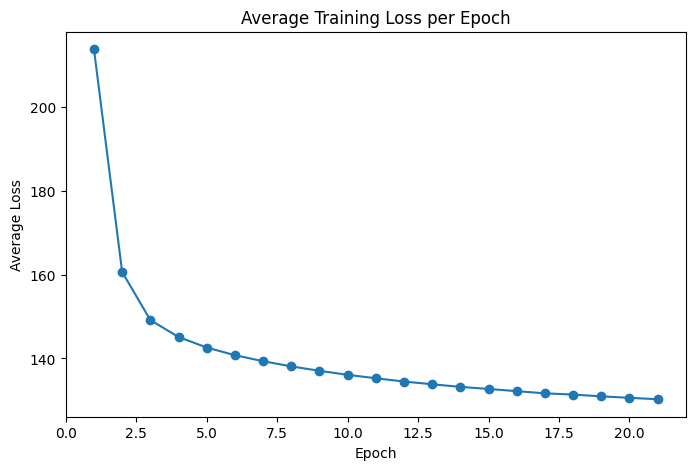

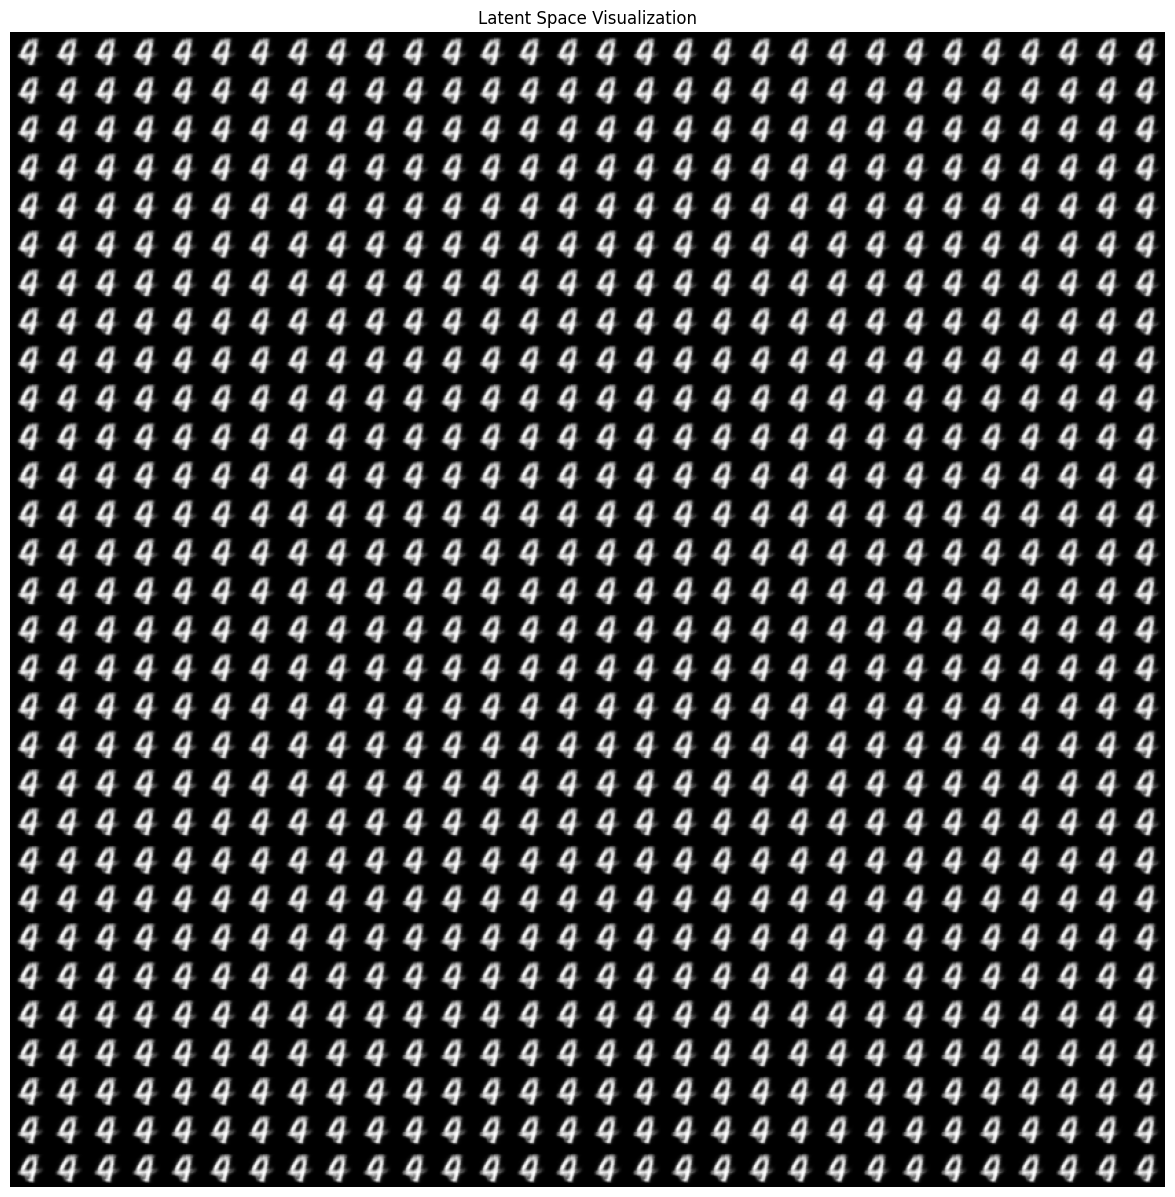

In [57]:
latent_dim = 10
save_dir = 'experiment2'
experiment_name = 'exp2'

epochs = 21
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

train_losses = []
for epoch in range(epochs):
  vae.train()

  train_loss = 0
  for batch in train_loader:
    x, _ = batch
    x = x.to(device)
    optimizer.zero_grad()
    recon_x, mu, logvar = vae(x)
    loss = loss_function(recon_x, x, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()

  avg_loss = train_loss / len(train_loader.dataset)
  train_losses.append(avg_loss)
  print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

  if epoch % 5 == 0:
    show_generation(vae, epoch+1, latent_dim, device, save_dir)

# Plot loss
plot_training_loss(train_losses, save_dir)

# Save model
save_model(vae, save_dir)

# Load model
model_loaded = VAE(latent_dim).to(device)
model_loaded.load_state_dict(torch.load(f'{save_dir}/{experiment_name}_vae_model.pt'))

# Plot latent space
plot_latent_space(model_loaded.decoder, save_dir, latent_dim)

# 7. Experiment 3. Updated loss function

In [58]:
def loss_function_mse(recon_x, x, mu, logvar, beta):
  recon_loss = F.mse_loss(recon_x, x, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return recon_loss + beta * kl_loss

Epoch 1, Loss: 57.8484


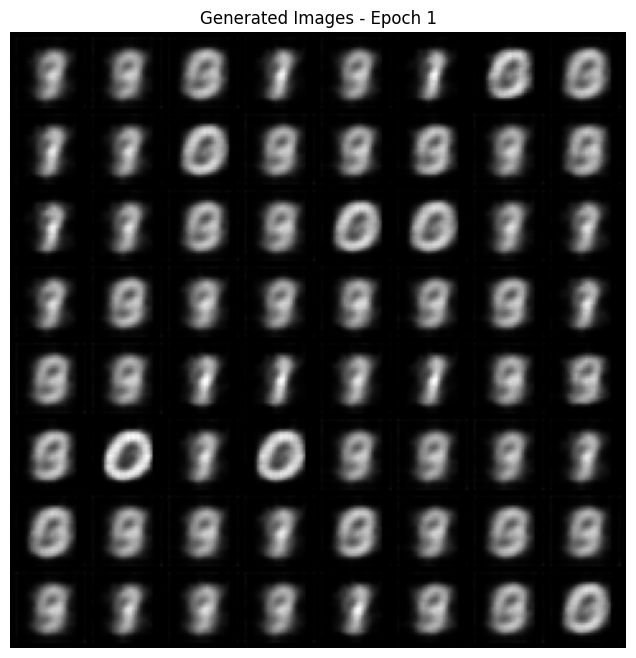

Epoch 2, Loss: 50.9613
Epoch 3, Loss: 49.9618
Epoch 4, Loss: 49.4182
Epoch 5, Loss: 49.2009
Epoch 6, Loss: 49.0508


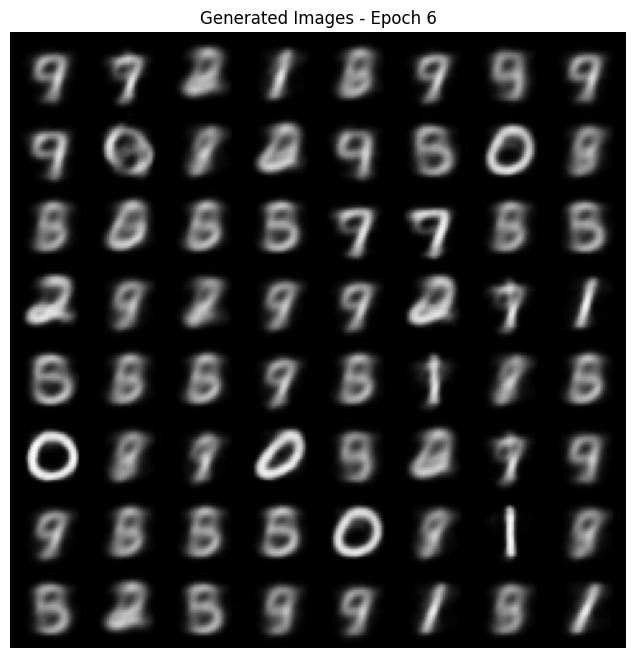

Epoch 7, Loss: 49.0161
Epoch 8, Loss: 48.9104
Epoch 9, Loss: 48.8458
Epoch 10, Loss: 48.8153
Epoch 11, Loss: 48.8034


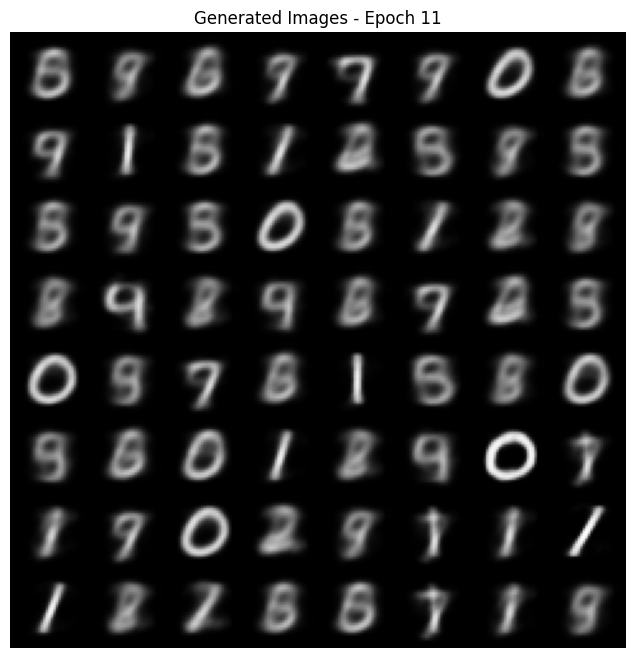

Epoch 12, Loss: 48.7210
Epoch 13, Loss: 48.6907
Epoch 14, Loss: 48.6811
Epoch 15, Loss: 48.6530
Epoch 16, Loss: 48.6267


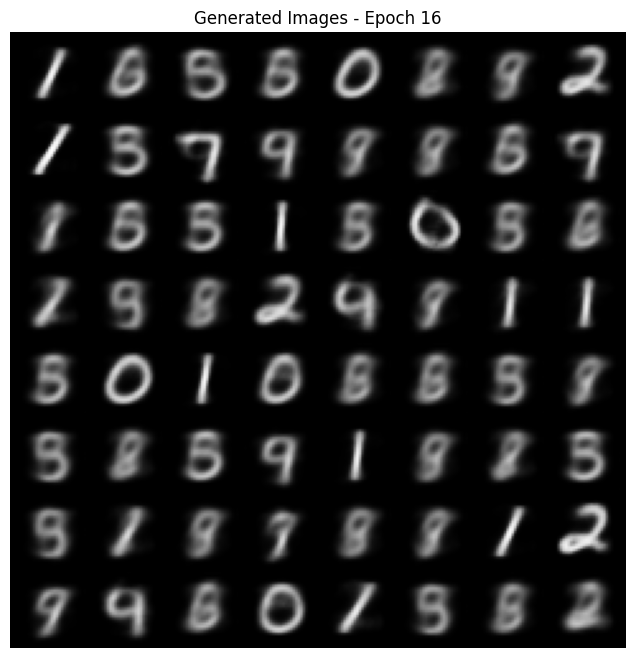

Epoch 17, Loss: 48.6160
Epoch 18, Loss: 48.5494
Epoch 19, Loss: 48.5579
Epoch 20, Loss: 48.5488
Epoch 21, Loss: 48.4918


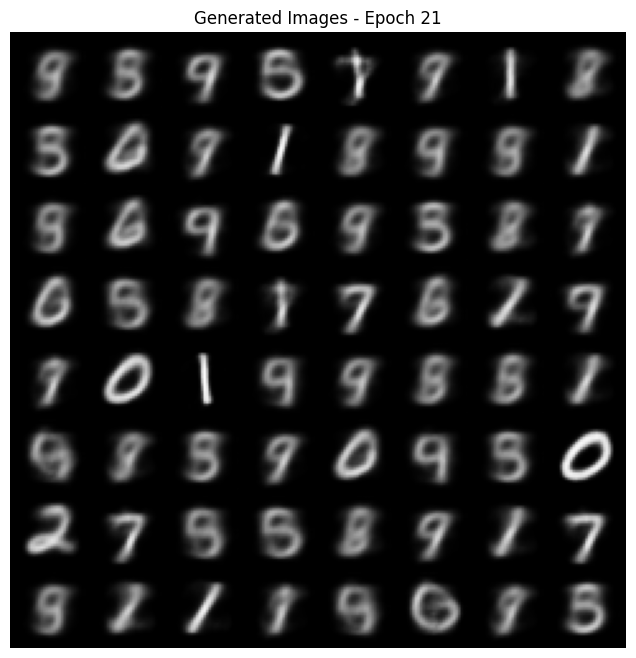

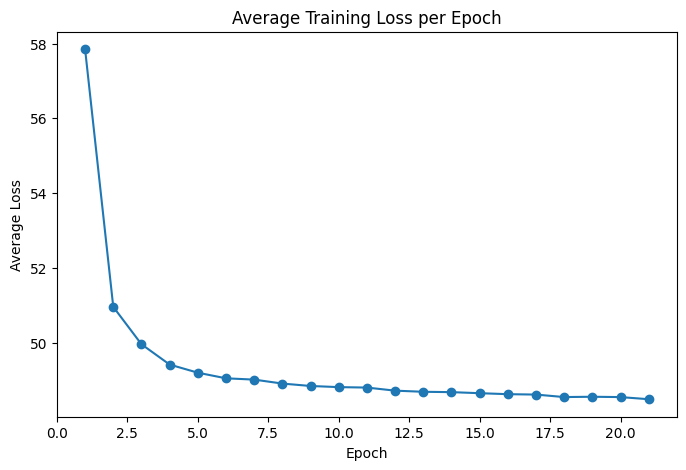

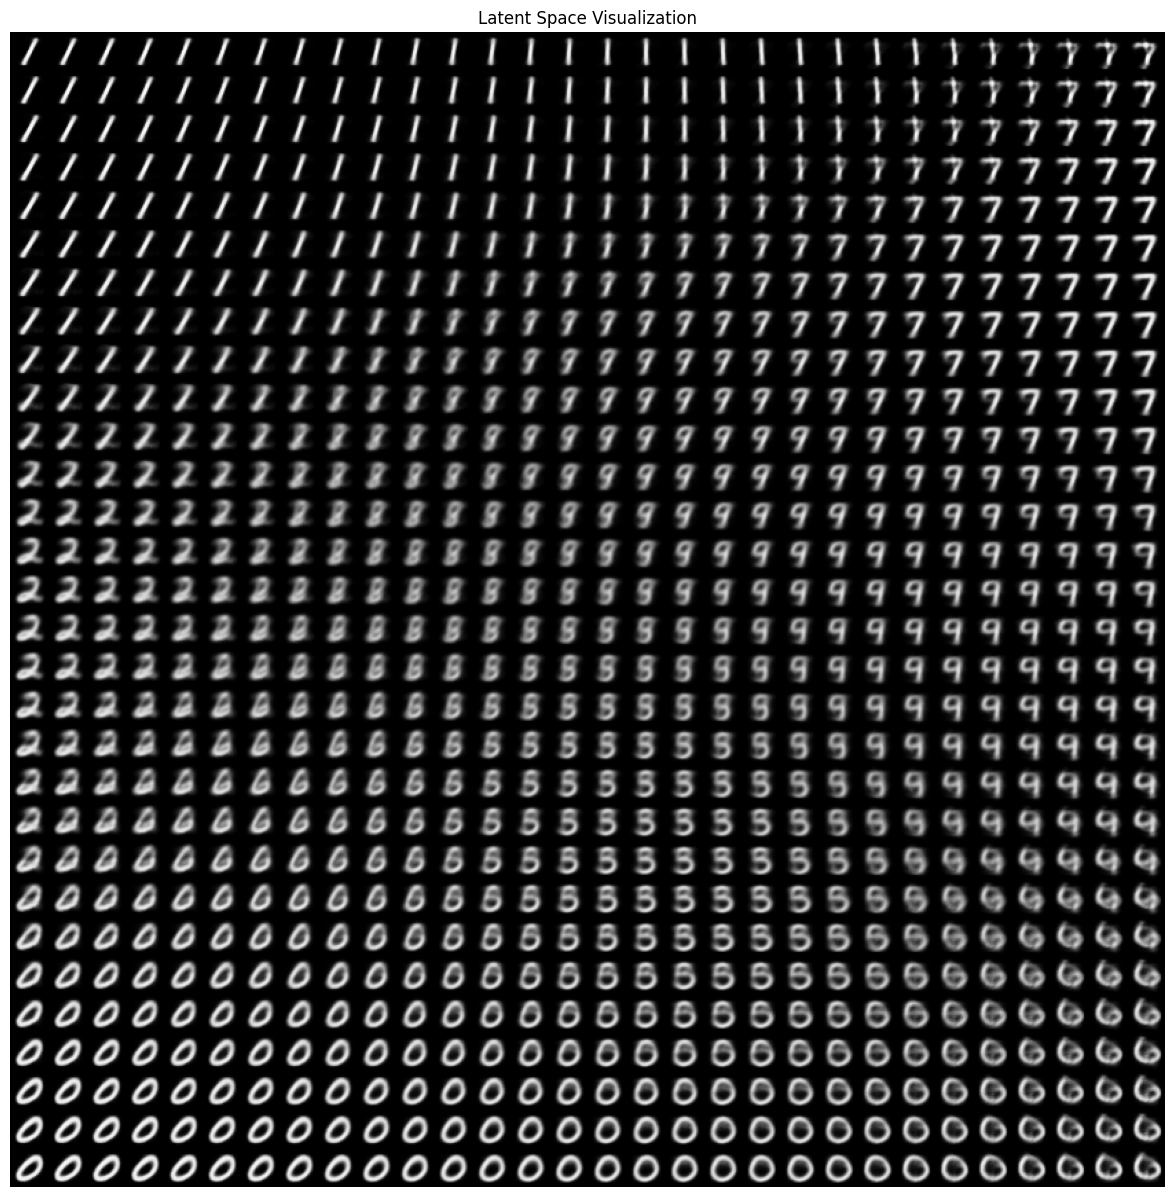

In [60]:
latent_dim = 2
save_dir = 'experiment3'
experiment_name = 'exp3'

epochs = 21
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

train_losses = []
for epoch in range(epochs):
  vae.train()

  train_loss = 0
  for batch in train_loader:
    x, _ = batch
    x = x.to(device)
    optimizer.zero_grad()
    recon_x, mu, logvar = vae(x)
    loss = loss_function_mse(recon_x, x, mu, logvar, beta=4)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()

  avg_loss = train_loss / len(train_loader.dataset)
  train_losses.append(avg_loss)
  print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

  if epoch % 5 == 0:
    show_generation(vae, epoch+1, latent_dim, device, save_dir)

# Plot loss
plot_training_loss(train_losses, save_dir)

# Save model
save_model(vae, save_dir)

# Load model
model_loaded = VAE(latent_dim).to(device)
model_loaded.load_state_dict(torch.load(f'{save_dir}/{experiment_name}_vae_model.pt'))

# Plot latent space
plot_latent_space(model_loaded.decoder, save_dir, latent_dim)

In [65]:
backup_colab_content_to_drive('robot_dreams/HW/')

Backup complete. Files saved to: /content/drive/MyDrive/robot_dreams/HW/
